In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm
from scipy.fft import fft, ifft
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import warnings
import random

warnings.filterwarnings("ignore")

SEED = 255
np.random.seed(SEED)
random.seed(SEED)

df = pd.read_csv('apple_daily_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.sort_index()
df = df.asfreq('B') 
df['close'] = df['close'].ffill()  

def gph_estimate(series, m=None):
    series = np.log(series + 1e-5) 
    n = len(series)
    if m is None:
        m = int(n ** 0.5)
    freqs = 2 * np.pi * np.arange(1, m + 1) / n
    periodogram = np.abs(fft(series - np.mean(series)))[:m+1]**2 / (2 * np.pi * n)
    y = np.log(periodogram[1:m + 1])
    x = np.log(4 * (np.sin(freqs / 2) ** 2))
    slope, _, _, _, _ = stats.linregress(x, y)
    d_estimate = -slope / 2
    return d_estimate

def _ma_model(params, n_points, *, noise_std=1, noise_alpha=2):
    ma_order = len(params)
    if noise_alpha == 2:
        noise = norm.rvs(scale=noise_std, size=(n_points + ma_order), random_state=SEED)
    else:
        noise = levy_stable.rvs(noise_alpha, 0, scale=noise_std, size=(n_points + ma_order), random_state=SEED)
    if ma_order == 0:
        return noise
    ma_coeffs = np.append([1], params)
    ma_series = np.zeros(n_points)
    for idx in range(ma_order, n_points + ma_order):
        take_idx = np.arange(idx, idx - ma_order - 1, -1).astype(int)
        ma_series[idx - ma_order] = np.dot(ma_coeffs, noise[take_idx])
    return ma_series[ma_order:]

def _arma_model(params, noise):
    ar_order = len(params)
    if ar_order == 0:
        return noise
    n_points = len(noise)
    arma_series = np.zeros(n_points + ar_order)
    for idx in np.arange(ar_order, len(arma_series)):
        take_idx = np.arange(idx - 1, idx - ar_order - 1, -1).astype(int)
        arma_series[idx] = np.dot(params, arma_series[take_idx]) + noise[idx - ar_order]
    return arma_series[ar_order:]

def _frac_diff(x, d):
    def next_pow2(n):
        return (n - 1).bit_length()
    n_points = len(x)
    fft_len = 2 ** next_pow2(2 * n_points - 1)
    prod_ids = np.arange(1, n_points)
    frac_diff_coefs = np.append([1], np.cumprod((prod_ids - d - 1) / prod_ids))
    dx = ifft(fft(x, fft_len) * fft(frac_diff_coefs, fft_len))
    return np.real(dx[0:n_points])

def arfima(ar_params, d, ma_params, n_points, *, noise_std=1, noise_alpha=2, warmup=0):
    ma_series = _ma_model(ma_params, n_points + warmup, noise_std=noise_std, noise_alpha=noise_alpha)
    frac_ma = _frac_diff(ma_series, -d)
    series = _arma_model(ar_params, frac_ma)
    return series[-n_points:]

def frac_diff(series, d, thresh=1e-5):
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thresh:
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    diff_series = np.zeros_like(series, dtype='float64')
    for i in range(len(w), len(series)):
        window = series[i - len(w):i]
        diff_series[i] = np.dot(w.T, window)
    return diff_series[len(w):]

forecast_horizon = 30
close_series_full = df["close"].values
train_series = close_series_full[:-forecast_horizon]
test_series = close_series_full[-forecast_horizon:]

d_est_train = gph_estimate(train_series)
fd_train = frac_diff(train_series, d_est_train)

aic_vals = []
orders = [(p, q) for p in range(4) for q in range(4)]
for p, q in orders:
    try:
        model = ARIMA(fd_train, order=(p, 0, q)).fit()
        aic_vals.append((model.aic, p, q))
    except:
        continue

_, best_p, best_q = sorted(aic_vals)[0]

final_model = ARIMA(fd_train, order=(best_p, 0, best_q)).fit()
ar_params = final_model.arparams.tolist()
ma_params = final_model.maparams.tolist()

forecast_train = arfima(ar_params, d_est_train, ma_params, forecast_horizon)

forecast_rescaled_train = forecast_train + train_series[-1]

min_len = min(len(forecast_rescaled_train), len(test_series))
forecast_rescaled_train = forecast_rescaled_train[:min_len]
test_series = test_series[:min_len]

print("ARFIMA Forecast vs Actual:\n")
for i in range(min_len):
    print(f"Day {i+1}: Forecast = {forecast_rescaled_train[i]:.2f}, Actual = {test_series[i]:.2f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(test_series, forecast_rescaled_train))
mae = mean_absolute_error(test_series, forecast_rescaled_train)

print(f"\nRMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


ARFIMA Forecast vs Actual:

Day 1: Forecast = 256.28, Actual = 255.59
Day 2: Forecast = 254.00, Actual = 252.20
Day 3: Forecast = 250.69, Actual = 250.42
Day 4: Forecast = 248.76, Actual = 250.42
Day 5: Forecast = 247.10, Actual = 243.85
Day 6: Forecast = 244.48, Actual = 243.36
Day 7: Forecast = 242.21, Actual = 245.00
Day 8: Forecast = 240.14, Actual = 242.21
Day 9: Forecast = 240.53, Actual = 242.70
Day 10: Forecast = 239.09, Actual = 242.70
Day 11: Forecast = 239.53, Actual = 236.85
Day 12: Forecast = 238.77, Actual = 234.40
Day 13: Forecast = 238.18, Actual = 233.28
Day 14: Forecast = 237.12, Actual = 237.87
Day 15: Forecast = 233.77, Actual = 228.26
Day 16: Forecast = 233.97, Actual = 229.98
Day 17: Forecast = 234.96, Actual = 229.98
Day 18: Forecast = 232.55, Actual = 222.64
Day 19: Forecast = 231.06, Actual = 223.83
Day 20: Forecast = 230.23, Actual = 223.66
Day 21: Forecast = 229.24, Actual = 222.78
Day 22: Forecast = 229.01, Actual = 229.86
Day 23: Forecast = 228.01, Actual =

In [16]:
mean_actual = np.mean(test_series)
rmse_ratio = rmse / mean_actual
mae_ratio = mae / mean_actual

print(f"RMSE Ratio: {rmse_ratio:.4%}")
print(f"MAE Ratio: {mae_ratio:.4%}")

RMSE Ratio: 3.2657%
MAE Ratio: 2.2653%


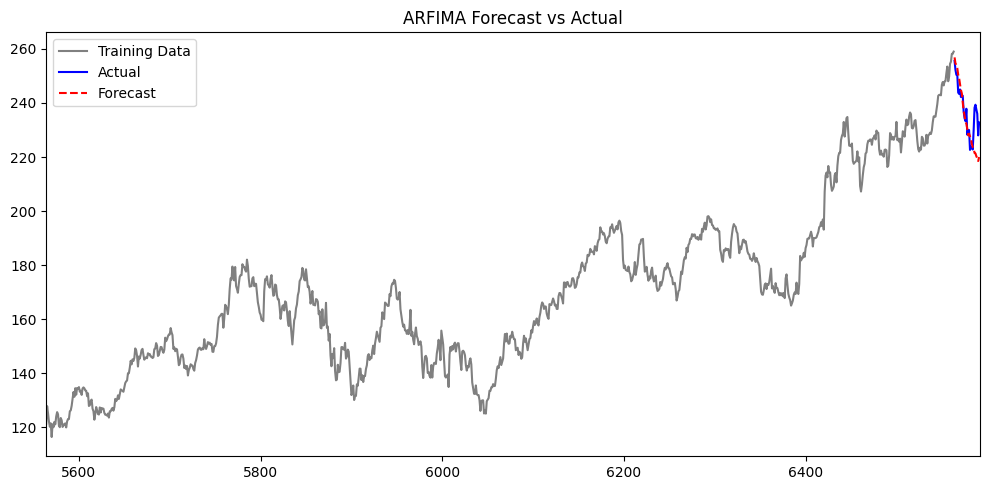

In [10]:
x_test = range(len(train_series), len(train_series) + min_len)

context_length = 1000
x_context = range(len(train_series) - context_length, len(train_series))

plt.figure(figsize=(10, 5))
plt.plot(x_context, train_series[-context_length:], label="Training Data", color='gray')
plt.plot(x_test, test_series, label="Actual", color='blue')
plt.plot(x_test, forecast_rescaled_train, label="Forecast", color='red', linestyle='--')

plt.xlim(len(train_series) - context_length, len(train_series) + min_len)

plt.title("ARFIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
close_series = df["close"].values
d_est = gph_estimate(close_series)
fd_close = frac_diff(close_series, d_est)

aic_vals = []
orders = [(p, q) for p in range(4) for q in range(4)]
for p, q in orders:
    try:
        model = ARIMA(fd_close, order=(p, 0, q)).fit()
        aic_vals.append((model.aic, p, q))
    except:
        continue

_, best_p, best_q = sorted(aic_vals)[0]
final_model = ARIMA(fd_close, order=(best_p, 0, best_q)).fit()
ar_params = final_model.arparams.tolist()
ma_params = final_model.maparams.tolist()

In [10]:
d_est

0.513291633568585

In [11]:
fd_close

array([-0.13244398, -0.19755302, -0.18997877, ..., -2.28108931,
        6.63458131,  4.81036737])

In [12]:
forecast_horizon = 30
forecast = arfima(ar_params, d_est, ma_params, forecast_horizon)
forecast_rescaled = forecast + close_series[-1]

print("Estimated d:", d_est)
print("Best AR order:", best_p)
print("Best MA order:", best_q)
print("Forecast (next 30 values):")
print(forecast)

Estimated d: 0.513291633568585
Best AR order: 3
Best MA order: 2
Forecast (next 30 values):
[ -2.14244849  -4.41036787  -4.87715892  -6.13197539  -8.55227546
  -9.85400529 -12.06682384 -14.18364832 -15.49183818 -18.86615118
 -21.94788318 -23.77185396 -25.97474892 -26.76926306 -28.70690227
 -31.06247057 -30.45483031 -31.4903182  -32.16951227 -34.27405675
 -35.44074981 -35.91396631 -37.62404743 -37.76535817 -38.85242729
 -39.59740507 -40.61798432 -39.15596722]


In [13]:
forecast_rescaled

array([231.07755151, 228.80963213, 228.34284108, 227.08802461,
       224.66772454, 223.36599471, 221.15317616, 219.03635168,
       217.72816182, 214.35384882, 211.27211682, 209.44814604,
       207.24525108, 206.45073694, 204.51309773, 202.15752943,
       202.76516969, 201.7296818 , 201.05048773, 198.94594325,
       197.77925019, 197.30603369, 195.59595257, 195.45464183,
       194.36757271, 193.62259493, 192.60201568, 194.06403278])

In [14]:
future_dates = pd.date_range(df.index[-1], periods=29, freq='B')[1:]
dff = pd.DataFrame(forecast_rescaled, index=future_dates, columns=['forecast'])
dff.to_csv('forecasted.csv')